## Quick MNIST example

#### Imports

In [24]:
!pip install wget

import os
import sys
import torch
import torchsummary
import wget
import tensorboard
import torchvision
import matplotlib.pyplot as plt
import pandas as pd

sys.path.insert(0, os.path.abspath("../.."))

import numpy as np
import vegans.utils.loading as loading
import vegans.utils.utils as utils
from vegans.GAN import ConditionalVanillaGAN, ConditionalPix2Pix, ConditionalLSGAN

In [25]:
from clearml import Task
task = Task.init('vegans', 'mnist-toy')
task.execute_remotely('gpu_support')

ClearML Task: created new task id=6cd431d367794134905c6f2cf78ce40d
ClearML results page: http://clearml.mlops.unit8/projects/a66576707b9b4067aaa75a2c9c77afda/experiments/6cd431d367794134905c6f2cf78ce40d/output/log
2021-05-17 19:30:33,964 - clearml.Task - INFO - Waiting for repository detection and full package requirement analysis
2021-05-17 19:30:34,031 - clearml.Task - INFO - Finished repository detection and package analysis
2021-05-17 19:30:35,224 - clearml - WARNING - Switching to remote execution, output log page http://clearml.mlops.unit8/projects/a66576707b9b4067aaa75a2c9c77afda/experiments/6cd431d367794134905c6f2cf78ce40d/output/log
2021-05-17 19:30:35,225 - clearml - WARNING - Terminating local execution process


NameError: name 'exit' is not defined

ClearML Task: created new task id=af63cf619e6a456dba0d1f442d8fc7a3
ClearML results page: http://clearml.mlops.unit8/projects/a66576707b9b4067aaa75a2c9c77afda/experiments/af63cf619e6a456dba0d1f442d8fc7a3/output/log
ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring
ClearML Monitor: Could not detect iteration reporting, falling back to iterations as seconds-from-start


In [3]:
#! pip install ipywidgets
#! jupyter nbextension enable --py widgetsnbextension

#### Load Data

In [2]:
#loader = loading.MNISTLoader()
#X_train, y_train, X_test, y_test = loader.load()
#print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

#x_dim = X_train.shape[1:]
#y_dim = y_train.shape[1:]

(60000, 1, 32, 32) (60000, 10) (10000, 1, 32, 32) (10000, 10)


In [3]:
loader = loading.CelebALoader(batch_size=64, max_loaded_images=5000, output_shape=32)
train_dataloader = loader.load()
print(len(train_dataloader))

X_train, y_train = iter(train_dataloader).next()
x_dim = X_train.numpy().shape[1:]
y_dim = y_train.numpy().shape[1:]
print(x_dim, y_dim)

3166
(3, 32, 32) (40,)


#### Preprocessing

In [4]:
z_dim = 128
epochs = 10

#### Define architecture

In [14]:
generator = loader.load_generator(x_dim=x_dim, z_dim=z_dim, y_dim=y_dim)
discriminator = loader.load_adversary(x_dim=x_dim, y_dim=y_dim, adv_type="Discriminator")

gan_model = ConditionalPix2Pix(
    generator=generator, adversary=discriminator,
    x_dim=x_dim, z_dim=z_dim, y_dim=y_dim,
    optim=None, optim_kwargs=None,                # Optional
    feature_layer=None,                           # Optional
    fixed_noise_size=32,                          # Optional
    device=None,                                  # Optional
    ngpu=None,                                    # Optional
    secure=True                                   # Optional
)
gan_model.summary()

Generator
---------
Input shape:  (168,)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1024]         173,056
         LeakyReLU-2                 [-1, 1024]               0
            Linear-3                 [-1, 8192]       8,396,800
         LeakyReLU-4                 [-1, 8192]               0
      LayerReshape-5            [-1, 128, 8, 8]               0
   ConvTranspose2d-6            [-1, 128, 8, 8]         147,584
       BatchNorm2d-7            [-1, 128, 8, 8]             256
         LeakyReLU-8            [-1, 128, 8, 8]               0
   ConvTranspose2d-9            [-1, 128, 8, 8]         147,584
      BatchNorm2d-10            [-1, 128, 8, 8]             256
        LeakyReLU-11            [-1, 128, 8, 8]               0
  ConvTranspose2d-12           [-1, 64, 16, 16]         131,136
      BatchNorm2d-13           [-1, 64, 16, 16]             12

#### Train model

In [18]:
gan_model.fit(
    X_train=train_dataloader,
    y_train=None,
    X_test=None,           # Optional
    y_test=None,           # Optional
    batch_size=32,           # Optional
    epochs=epochs,                # Optional
    steps=None,              # Optional
    print_every="0.2e",      # Optional
    save_model_every=None,   # Optional
    save_images_every="0.2e",  # Optional
    save_losses_every=10,    # Optional
    enable_tensorboard=False # Optional
)

------------------------------------------------------------
EPOCH: 1
------------------------------------------------------------


KeyboardInterrupt: 

#### Evaluation

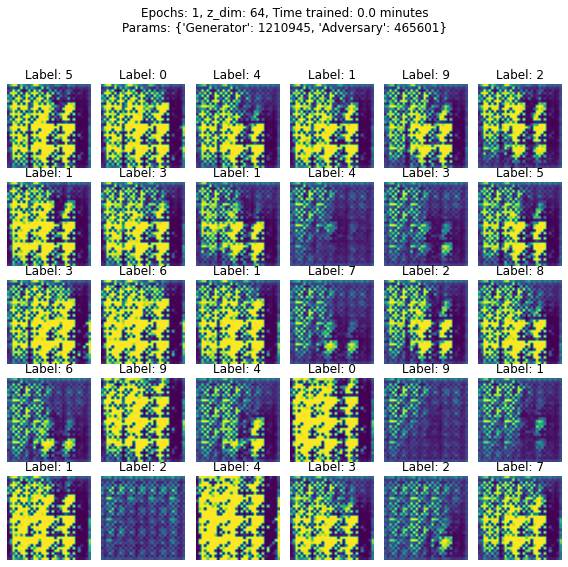

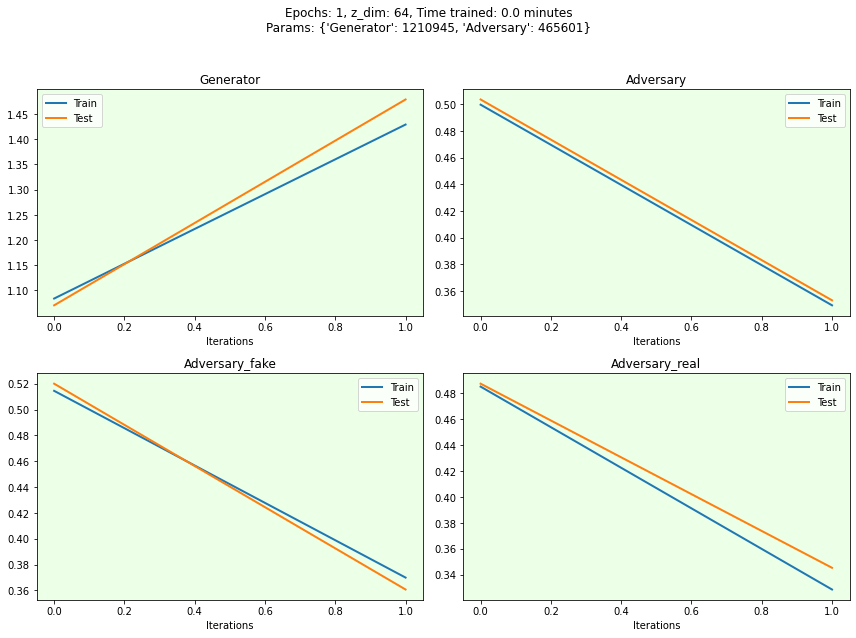

In [23]:
samples, losses = gan_model.get_training_results(by_epoch=False)

training_time = np.round(gan_model.total_training_time/60, 2)
title = "Epochs: {}, z_dim: {}, Time trained: {} minutes\nParams: {}\n\n".format(
    epochs, z_dim, training_time, gan_model.get_number_params()
)
fixed_labels = np.argmax(gan_model.get_fixed_labels(), axis=1)
fig, axs = utils.plot_images(images=samples, labels=fixed_labels, show=False)
fig.suptitle(title, fontsize=12)
fig.tight_layout()
plt.savefig(gan_model.folder+"/generated_images.png")

fig, axs = utils.plot_losses(losses=losses, show=False)
fig.suptitle(title, fontsize=12)
fig.tight_layout()
plt.savefig(gan_model.folder+"/losses.png")

In [ ]:
task.upload_artifact('LoggedFolder', artifact_object=os.path.join(gan_model.folder))